## Les imports

### Charger la lib popup

In [12]:
#pour colab, sinon changer le chemin "/content" ou supprimer ce test
import os
if os.path.exists("/content"):
    !git init
    !git pull https://github.com/vincentvigon/RECHERCHE3.git
    %ls
else:
    print("on n'est pas sur colab")

import popup_lib.popup as pop

Reinitialized existing Git repository in /content/.git/
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/vincentvigon/RECHERCHE3
 * branch            HEAD       -> FETCH_HEAD
Updating 0a48906..ff7966c
Fast-forward
 popup_lib/popup.py               | 1 +
 popup_lib/vitrine de popup.ipynb | 2 +-
 2 files changed, 2 insertions(+), 1 deletion(-)
ddqn_lib/  GCN.zip       model_1.h5     Pinns/        transformer/
Euler/     Hamilton/     model_2.h5     popup_lib/
GCN/       Hamilton.zip  model_vNet.h5  sample_data/


### Lib standarts

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from typing import *
import tensorflow as tf

## Un exemple ultra simple

Un agent qui cherche a augmenter la somme de ses deux poids.

### Définissons un agent

In [14]:
class Agent_ultra_toy(pop.Abstract_Agent):

    def __init__(self):
        self.wei0=np.array([0.])
        self.wei1=np.array([0.])
        self.famparams={"add0":0,"add1":0}

    #Abstract_Agent: obligatoire
    def get_famparams(self):
        return self.famparams

    #Abstract_Agent: obligatoire
    def set_and_perturb_famparams(self,famparams,period_count):
        self.famparams=famparams

        if np.random.random()<0.5:
            self.famparams["add0"]+=1
        else:
            self.famparams["add1"]-=1

    #Abstract_Agent: obligatoire
    def optimize_and_return_score(self) -> float:
        #c'est pas vraiment une optimization ici
        self.wei0 +=self.famparams["add0"]
        self.wei1 +=self.famparams["add1"]
        return self.return_score()

    #Abstract_Agent: obligatoire
    def set_weights(self, weights):
        self.wei0,self.wei1=weights

    #Abstract_Agent: obligatoire
    def get_copy_of_weights(self):
        return self.wei0,self.wei1


    #Abstract_Agent: facultatif: pour ajouter des métriques
    #def to_register_at_period_end(self) ->Dict[str,float]:
    #je ne l'ai pas implémenter pour cet agent

    #Abstract_Agent: facultatif: pour faire des tests
    def return_score(self)-> float:
        return self.wei0[0] + self.wei1[0]

    #Abstract_Agent: facultatif: pour observer les poids
    def to_register_at_period_end(self) ->Dict[str,float]:
        return {"wei0":self.wei0[0],"wei1":self.wei1[0]}

### Entrainons une famille d'agent

In [15]:
agents=[Agent_ultra_toy(), Agent_ultra_toy()]
family_trainer=pop.Family_trainer(agents,period_duration="10 steps",nb_strong=1)

for _ in range(20):
    family_trainer.period()


fam_3,échauffement a↗0.0b↗0.0
fam_3,period:1 ----------
/!\ L'agent:a est décadent pour la 0-ième fois consécutive; record:0.0, scores courants:deque([0.0, 0.0, 0.0], maxlen=3), best_famparams: {'add0': 0, 'add1': 0} 
, mutations:a⇇b|a⇇b↫a|
fam_3,period:2 ----------
/!\ L'agent:a est décadent pour la 1-ième fois consécutive; record:0.0, scores courants:deque([-3.0, -4.0, -5.0], maxlen=3), best_famparams: {'add0': 0, 'add1': 0} 
, mutations:a⇇b↫a⇇b|a⇇b↫a⇇b↫a|
fam_3,period:3 a↗1.0-a↗2.0-a↗3.0-a↗4.0-a↗5.0-
/!\ L'agent:b est décadent pour la 0-ième fois consécutive; record:0.0, scores courants:deque([0.0, 0.0, 0.0], maxlen=3), best_famparams: {'add0': 0, 'add1': 0} 
, mutations:b⇇a|b⇇a↫b|
fam_3,period:4 a↗6.0b↗7.0a↗7.0b↗9.0a↗8.0b↗11.0a↗9.0b↗13.0a↗10.0b↗15.0
/!\ L'agent:a est décadent pour la 2-ième fois consécutive; record:10.0, scores courants:deque([8.0, 9.0, 10.0], maxlen=3), best_famparams: {'add0': 1, 'add1': 0} 
, mutations:a⇇b↫a⇇b↫a⇇b|a⇇b↫a⇇b↫a⇇b⇇b|
fam_3,period:5 a↗18.0b↗17.0a↗21.

### Observons les résultats

KeyError: ignored

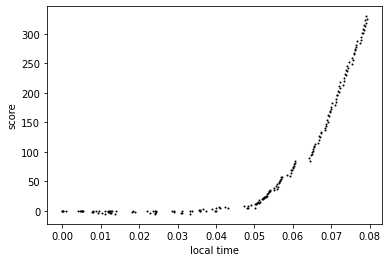

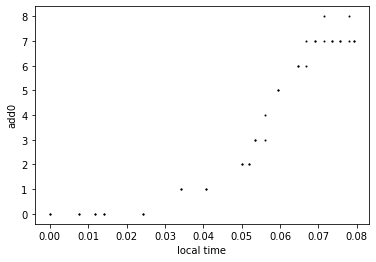

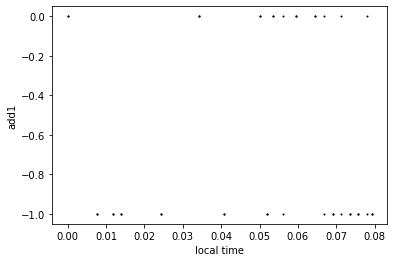

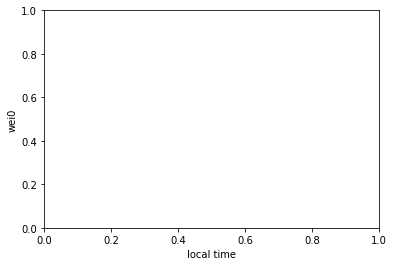

In [7]:
family_trainer.plot_metric("score")
family_trainer.plot_metric("add0")
family_trainer.plot_metric("add1")

family_trainer.plot_metric("wei0")
family_trainer.plot_metric("wei1")

In [ ]:
print("\nstats_of_best:",family_trainer.stats_of_best())

### Testons le meilleur agent

In [ ]:
best_agent=family_trainer.get_best_agent()
scores=[]
for _ in range(5):
    scores.append(best_agent.return_score())
fig,ax=plt.subplots()
ax.set_title("best agent test")
ax.plot(scores)
plt.show()

Tout c'est passé comme prévu


## Trouver le minimum d'une fonction

### Présentation du problème

On cherche à minimiser la fonction ci-dessous:

In [ ]:
def loss_fn(x:tf.Variable,y:tf.Variable):
    difficulty=0.5 # avec 0.1 l'optimisation devient très facile
    norm1=tf.abs(x)+tf.abs(y)
    return 3*norm1+ difficulty * (1 - tf.sin( x * y * 500))

def plot_loss_func(ax,r):

    x = np.linspace(-r, r, 100,dtype=np.float32)
    y = np.linspace(-r, r, 100,dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    Q = loss_fn(xx, yy)  ##1.2 - (xx ** 2 + yy ** 2)

    ax.set_aspect('equal')
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    ax.contourf(xx, yy, Q, 50, cmap='autumn')

_,ax=plt.subplots()
plot_loss_func(ax,1)

Elle a comme minimum 0 en (x,y)=(0,0).

On utilise une descente de gradient avec une vitesse différente
pour `x` et pour `y`

En essayant de mettre les paramètres à la main
on trouve pas forcément le minimum car la
fonction à minimiser `loss_fn` a une variabilité locale importante.
Les gradients partent un peu dans tous les sens; mais en moyenne
ils indiquent quand même le bon chemin.

### L'agent

In [ ]:
class Minimizer_agent(pop.Abstract_Agent):

    def __init__(self,set_and_perturb_famparams):
        Minimizer_agent.set_and_perturb_famparams=set_and_perturb_famparams
        self.weight0 = tf.Variable(np.random.uniform(-0.5,0.5))
        self.weight1 = tf.Variable(np.random.uniform(-0.5,0.5))
        self.famparams={"dir0":np.random.uniform(0,1e-1),"dir1":np.random.uniform(0,1e-1)}


    def get_famparams(self):
        return self.famparams


    def set_and_perturb_famparams(self,famparam,*period_count):
        raise Exception("to be defined in the constructor")


    def optimize_and_return_score(self):

        with tf.GradientTape() as tape:
            loss=loss_fn(self.weight0,self.weight1)
        gradients=tape.gradient(loss,[self.weight0,self.weight1])

        self.weight0.assign_sub(gradients[0] * self.famparams["dir0"])
        self.weight1.assign_sub(gradients[1] * self.famparams["dir1"])

        return -loss.numpy()


    def set_weights(self, weights):
        self.weight0.assign(weights[0])
        self.weight1.assign(weights[1])

    def get_copy_of_weights(self):
        return [self.weight0.numpy(),self.weight1.numpy()]

    def weights_info_to_register(self) ->Dict[str,float]:
        return {"wei0":self.weight0.numpy(),"wei1":self.weight1.numpy()}

### L'agent travail seul

In [ ]:
def minimize_by_hand():
    agent=Minimizer_agent(None)
    scores=[]
    weights0=[]
    weights1 = []
    for _ in range(20):
        score=agent.optimize_and_return_score()
        w0,w1=agent.get_copy_of_weights()
        weights0.append(w0)
        weights1.append(w1)
        scores.append(score)

    fig,ax=plt.subplots(1,1,figsize=(4,4))

    ax.set_title("scores")
    ax.set_ylim(-30,0)
    ax.plot(scores,".-")

    plt.show()
minimize_by_hand()

### En famille

Le familyTrainer s'en sort bien (la plupart du temps).

On définit trois familles:
* La famille `quiet` qui bouge tranquillement ses learning rates
* La famille `exited` qui les bouge beaucoup
* La famille `varying` qui bouge de moins en moins

In [ ]:
def main():

    def set_and_perturb_quiet(agent:Minimizer_agent,famparams,):
        agent.famparams["dir0"] =famparams["dir0"]*np.random.uniform(0.8, 1.2)
        agent.famparams["dir1"] =famparams["dir1"]* np.random.uniform(0.8, 1.2)

    def set_and_perturb_exited(agent: Minimizer_agent,famparams,):
        agent.famparams["dir0"] =famparams["dir0"]* np.random.uniform(0.2, 1.8)
        agent.famparams["dir1"] =famparams["dir1"]* np.random.uniform(0.2, 1.8)


    def set_and_perturb_changing(agent: Minimizer_agent,famparams,period_count):
        agent.famparams["dir0"] =famparams["dir0"]* np.random.uniform(0.2, 1.8)*0.95**period_count
        agent.famparams["dir1"] =famparams["dir1"]* np.random.uniform(0.2, 1.8)*0.95**period_count



    popsize = 10
    quiet_agents = [Minimizer_agent(set_and_perturb_quiet) for _ in range(popsize)]
    exited_agents = [Minimizer_agent(set_and_perturb_exited) for _ in range(popsize)]
    changing_agents = [Minimizer_agent(set_and_perturb_changing) for _ in range(popsize)]


    fam_trainers=[
                  pop.Family_trainer(quiet_agents,
                                 period_duration="30 steps",
                                 name="quiet",
                                 color="g"
                                 ),
                  pop.Family_trainer(exited_agents,
                                 period_duration="30 steps",
                                 name="exited",
                                 color="k"
                                 ),
                  pop.Family_trainer(changing_agents,
                                 period_duration="30 steps",
                                 name="varying",
                                 color="b"
                                 )
                  ]
    try:
        for i in range(30):
            for fm in fam_trainers:fm.period()

    except KeyboardInterrupt:
        print("interuption")

    fig,ax=plt.subplots()
    ax.set_ylim(0,0.2)
    ax.set_xlim(0,0.2)
    for fm in fam_trainers:fm.plot_two_metrics("dir0","dir1",ax)


    fig,ax=plt.subplots()
    r=5
    plot_loss_func(ax,r)
    ax.set_ylim(-r, r)
    ax.set_xlim(-r, r)
    for fm in fam_trainers:
        fm.plot_two_metrics("wei0", "wei1",ax)

    for fm in fam_trainers:
        fig,ax=plt.subplots()
        ax.set_ylim(-10,0)
        fm.plot_metric("score",ax)

    plt.show()

main()

## Un réseau convolutif

### Les data

In [ ]:
def present_fashion(X,Y):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    plt.figure(figsize=(10, 10))

    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i], cmap="gray")
        plt.xlabel(class_names[Y[i]])

    plt.show()

class XY_dealer:

    def __init__(self):
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (X_train, Y_train), (X_val_test, Y_val_test) = fashion_mnist.load_data()
        X_train = X_train / 255.0
        X_val_test = X_val_test / 255.0

        nb_val=5000
        self.X_val=X_val_test[:nb_val]
        self.Y_val=Y_val_test[:nb_val]

        self.X_test=X_val_test[nb_val:]
        self.Y_test=Y_val_test[nb_val:]

        self.X_train=X_train
        self.Y_train=Y_train

        self.shuffle()


    def get_XY_val(self):
        perm=np.random.permutation(len(self.X_val))
        return self.X_val[perm[:400]],self.Y_val[perm[:400]]


    def shuffle(self):
        #print("new epoch")
        perm=np.random.permutation(len(self.X_train))

        self.X_train_shuffle=self.X_train[perm]
        self.Y_train_shuffle=self.Y_train[perm]
        self.batch_count=0

    def get_XY_train(self,batch_size):
        i=self.batch_count
        self.batch_count+=1

        if (i+1)*batch_size>=len(self.X_train):
            self.shuffle()

        X_batch=self.X_train_shuffle[i*batch_size:(i+1)*batch_size]
        Y_batch = self.Y_train_shuffle[i * batch_size:(i + 1) * batch_size]

        return X_batch,Y_batch



XY_DEALER=XY_dealer()
X,Y=XY_DEALER.get_XY_train(25)
present_fashion(X,Y)

### L'agent


In [ ]:
class Agent_convo(pop.Abstract_Agent):

    def __init__(self,xy_dealer,lr,batch_size,conv_struc,dense_struc):

        self.batch_size=batch_size
        self.famparams = {"lr": lr}
        self.conv_struc=conv_struc
        self.dense_struc=dense_struc

        self.model= self.make_model()
        self.xy_dealer = xy_dealer
        self._count = -1

        self.make_optimizer()

    def get_famparams(self):
        return self.famparams


    def make_optimizer(self):
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.famparams["lr"])

    def set_and_perturb_famparams(self,famparams,period_count):
        self.famparams["lr"]=famparams["lr"]*np.random.uniform(0.5,5)
        self.make_optimizer()

    def make_model(self):
        inputs=tf.keras.layers.Input([28,28,1])

        current=inputs
        for nb_units in self.conv_struc:
            current=tf.keras.layers.Conv2D(nb_units,3)(current)

        current=tf.keras.layers.Flatten()(current)
        for nb_units in self.dense_struc:
            current=tf.keras.layers.Dense(nb_units,activation="softmax")(current)

        probas=tf.keras.layers.Dense(10,activation="softmax")(current)

        return tf.keras.Model(inputs=inputs,outputs=probas)


    def optimize_and_return_score(self) -> float:
        self._count+=1

        X,Y=self.xy_dealer.get_XY_train(self.batch_size)

        with tf.GradientTape() as tape:
            Y_pred=self.model(X)
            loss=tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(Y, Y_pred))

        gradients=tape.gradient(loss,self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.model.trainable_variables))

        X, Y = self.xy_dealer.get_XY_val()
        Y_pred = self.model(X)
        accuracy = tf.keras.metrics.sparse_categorical_accuracy(Y, Y_pred)
        return accuracy.numpy().mean()


    def set_weights(self, weights:List):
        self.model.set_weights(weights)

    def get_copy_of_weights(self) -> List:
        return self.model.get_weights()
        #res=[]
        #for tensor in self.model.get_weights():
        #    res.append(tensor) #get_weights tenvoie déjà des copies numpy
        #return res


### Création des familles

Maintenant on a des vraies grosses données.
L'appelle d'un `optimize_and_return_score` prend du temps.
Notre but est de comparer 2 architectures
de réseau de neurone: un lourd et un léger. On va définir la
durée des périod en nombre de seconde pour que les deux
familles s'entrainent autant de temps chacune.

In [ ]:
def rand_lr():
    return 10**np.random.uniform(-4,-2)

popsize = 5
agents_light=[Agent_convo(XY_DEALER,rand_lr(),64,conv_struc=(10,20,10),dense_struc=(50,)) for _ in range(popsize)]
agents_heavy=[Agent_convo(XY_DEALER,rand_lr(),64,conv_struc=(32,64,32),dense_struc=(512,)) for _ in range(popsize)]

family_trainers = [
    pop.Family_trainer(agents_light, period_duration="10 seconds",name="light",color="g"),
    pop.Family_trainer(agents_heavy, period_duration="10 seconds",name="heavy",color="r")
]


### Entrainement

In [ ]:
try:
    for _ in range(10):
        for fm in family_trainers:
            fm.period()
except KeyboardInterrupt:
    for family_trainer in family_trainers:
        #pour pouvoir reprendre si on veut
        family_trainer.interupt_period()
    print("interuption manuelle")

### Courbes d'entrainements

C'est très intéressant: 
* sur CPU l'agent léger gagne largement 
* sur GPU (colab) il y a égalité. 

In [ ]:
fig,ax=plt.subplots()
for fm in family_trainers:
    fm.plot_metric("score",ax)

_,ax=plt.subplots()
for fm in family_trainers:
    fm.plot_metric("lr",ax)

plt.show()

### Observons le meilleurs agent de chaque famille

In [ ]:
best_agents=[fm.get_best_agent() for fm in family_trainers]

for agent in best_agents:
    Y_pred=agent.model(XY_DEALER.X_test)
    accuracy = tf.keras.metrics.sparse_categorical_accuracy(XY_DEALER.Y_test, Y_pred)
    print(accuracy.numpy().mean())